In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from spikeship import spikeship
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch, os
from tqdm import tqdm
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import MDS, spectral_embedding, TSNE

/gs/home/grimaldiav/.conda/envs_ppc/ppc-spikeship/lib/python3.10/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/mnt/pns/home/grimaldiav/Documents/SpikeShip/spikeship/spikeship.py:254: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(int32(int32, int32))


In [3]:
def tensor2spikeship(rp_tensor):
    N_epochs, N_neurons, N_timesteps = rp_tensor.shape
    #epochs, neurons, times = np.where(rp_tensor>0)
    spike_times = np.array([])
    ii_spike_times = np.zeros([N_epochs, N_neurons, 2])
    nb_previous_timestamps = 0
    last_previous_timestamp = 0
    for e in tqdm(range(N_epochs)):
        neurons, times = np.where(rp_tensor[e,:,:]>0)
        for n in np.unique(neurons):
            indices = np.where(neurons==n)[0]
            ii_spike_times[e,n,:] = [indices[0], indices[-1]+1] + np.ones([2])*nb_previous_timestamps
            spike_times = np.hstack([spike_times,times[indices]]) if spike_times.shape[0]>0 else times[indices]
        nb_previous_timestamps += len(times)
        #last_previous_timestamp += times[-1]
    return spike_times, ii_spike_times

def plot_raster(raster, trial_nb = 0, colored=False, title = 'raster plot'):

    subplotpars = matplotlib.figure.SubplotParams(left=0.125, right=.95, bottom=0.25, top=.975, wspace=0.05, hspace=0.05,)

    xticks, yticks = 6, 16
    spikelength=.9
    colors = ['grey', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
 '#7f7f7f', '#bcbd22', '#17becf']
    figsize = (12, 1.61803)
    linewidths=1.0

    if colored:
        N_kernels, N_trials, N_neurons, N_timesteps = raster.shape
    else:
        N_trials, N_neurons, N_timesteps = raster.shape

    fig, ax = plt.subplots(1, 1, figsize=figsize, subplotpars=subplotpars)
    if colored:

        for i in range(0, N_neurons):
            for sm in range(N_kernels):
                ax.eventplot(np.where(raster[sm, trial_nb, i, :] > 0)[0],
                    colors=colors[sm], lineoffsets=1.*i+spikelength/2,
                    linelengths=spikelength, linewidths=linewidths)
    else:
        for i in range(0, N_neurons):
            ax.eventplot(np.where(raster[trial_nb, i, :] > 0)[0],
                colors=colors[0], lineoffsets=1.*i+spikelength/2,
                linelengths=spikelength, linewidths=linewidths)

    ax.set_ylabel('address')
    ax.set_xlabel('Time (a. u.)')
    ax.set_xlim(0, N_timesteps)
    ax.set_ylim(0, N_neurons)

    ax.set_yticks(np.arange(0, N_neurons, 1)+.5)
    ax.set_yticklabels('')#np.linspace(1, N_neurons, 9, endpoint=True).astype(int))
    for side in ['top', 'right']: ax.spines[side].set_visible(False)

    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(N_timesteps/4))
    ax.set_xticks(np.linspace(1, N_timesteps, xticks, endpoint=True))
    ax.set_xticklabels(np.linspace(1, N_timesteps, xticks, endpoint=True).astype(int))
    ax.set_title(title)

    ax.grid(visible=True, axis='y', linestyle='-', lw=.5)
    #ax.grid(visible=True, axis='x', which='both', linestyle='-', lw=.1)
    return fig, ax

def plot_SM(SMs, N_show = 5, cmap='plasma', colors=None, aspect=None, figsize = (12, 1.61803)):
    subplotpars = matplotlib.figure.SubplotParams(left=0.125, right=.95, bottom=0.25, top=.975, wspace=0.05, hspace=0.05,)

    N_SMs, N_pre, N_delays = SMs.shape

    fig, axs = plt.subplots(1, N_show, figsize=figsize, subplotpars=subplotpars)
    for i_SM in range(N_show):
        ax = axs[i_SM]
        ax.set_axisbelow(True)
        ax.pcolormesh(SMs[i_SM, :, :].flip(1), cmap=cmap, vmin=SMs.min(), vmax=SMs.max())
        #ax.imshow(self.SMs[:, i_SM, :], cmap=cmap, vmin=0, vmax=1, interpolation='none')
        ax.set_xlim(0, N_delays)
        ax.set_xlabel('Delay')
        t = ax.text(.805*N_delays, .95*N_pre, f'#{i_SM+1}', color='k' if colors is None else colors[i_SM])
        t.set_bbox(dict(facecolor='white', edgecolor='white'))
        if not aspect is None: ax.set_aspect(aspect)

        ax.set_ylim(0, N_pre)
        ax.set_yticks(np.arange(0, N_pre, 1)+.5)
        if i_SM>0:
            ax.set_yticklabels([])
        else:
            ax.set_yticklabels(np.arange(0, N_pre, 1)+1)

        for side in ['top', 'right']: ax.spines[side].set_visible(False)
        ax.set_xticks([1, N_delays//3, (N_delays*2)//3])
        ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(N_delays//4))

    axs[0].set_ylabel('@ Neuron')
    return fig, axs


def gaussian_kernel(n_steps, mu, std):
    x = torch.arange(n_steps)
    return torch.exp(-(x-mu)**2/(2*std**2))/(std*torch.sqrt(torch.Tensor([2*torch.pi])))

In [4]:
class SM_World:
    def __init__(self, opt, add_coef = None):
        # initialization of the parameters + drawing of the kernels
        # here one of the kernels is a combination of the 2 first ones with parameter add_coef ([0,1])
        self.opt: Params = opt
        if add_coef:
            self.kernels = torch.zeros(self.opt.N_kernels+1, self.opt.N_pre, self.opt.N_delays)
        else:
            self.kernels = torch.zeros(self.opt.N_kernels, self.opt.N_pre, self.opt.N_delays)

        for k in range(self.kernels.shape[0]):
            nb_spikes = int(torch.normal(torch.Tensor([self.opt.avg_N_spikes]), torch.Tensor([self.opt.std_N_spikes])).abs())
            addr, delay, precision = (torch.randint(self.opt.N_pre, [nb_spikes]), torch.randint(self.opt.N_delays, [nb_spikes]), torch.normal(torch.ones([nb_spikes])*self.opt.avg_precision, torch.ones([nb_spikes])*self.opt.std_precision).abs())
            for s in range(nb_spikes):
                self.kernels[k, addr[s], :] += gaussian_kernel(self.opt.N_delays, delay[s], 1/precision[s])
            if self.kernels[k, :, :].max()>1: self.kernels[k, :,:]/=self.kernels[k, :, :].max()
        if add_coef:
            self.kernels[-1, :, :] = (1-add_coef)*self.kernels[0, :, :] + add_coef*self.kernels[1, :, :]

    def draw_input_one_sm(self, N_trials = 1, do_channels = False):

        spontaneous_activity = torch.bernoulli(torch.ones([N_trials, self.opt.N_pre, self.opt.N_timesteps])*self.opt.p_spontaneous)

        labels = torch.randint(self.kernels.shape[0], [N_trials])

        if do_channels:
            input_rp_with_channels = torch.zeros([self.kernels.shape[0]+1, N_trials, self.opt.N_pre, self.opt.N_timesteps])
            for k in labels.unique():
                indices = labels==k
                trials = torch.bernoulli(self.kernels[k,:,:].unsqueeze(0).repeat(indices.sum(),1,1))
                input_rp_with_channels[k+1,indices,:,:] = trials
                input_rp_with_channels[0,indices,:,:] = spontaneous_activity[indices,:,:]
            return input_rp_with_channels, labels
        else:
            input_rp = torch.zeros([N_trials, self.opt.N_pre, self.opt.N_timesteps])
            for k in labels.unique():
                indices = labels==k
                trials = torch.bernoulli(self.kernels[k,:,:].unsqueeze(0).repeat(indices.sum(),1,1))
                input_rp[indices,:,:] = torch.max(trials, spontaneous_activity[indices])
            return input_rp, labels


In [5]:
class world_params:
    N_pre = 200 # number of neurons in the RP
    N_delays = 51 # number of timesteps in the SM (must be an odd number for convolutions)
    N_kernels = 2 # number of SM used for RP generation

    p_input = .05 # global probability of having a spike in the timebins of the RP as input
    sm_ratio = .5 # probability of a spike as input to belong to the SM
    p_spontaneous =  p_input*(1-sm_ratio)
    p_spike_in_motif = p_input*sm_ratio # probability of having a spike in the timebins of the SM

    avg_N_spikes = p_spike_in_motif*N_delays*N_pre
    std_N_spikes = 1

    N_timesteps =  N_delays # number of timesteps in the RP

    avg_precision = 10 # average precision for the spikes in the SM (inverse of variance of the gaussian distribution defined for 1 spike)
    std_precision = 1 # variance for the precision

    seed = 4815162342 # seed

    # N_pre         = 50 #20 # number of neurons in the RP
    # N_delays      = 401 # 51 # number of timesteps in the SM (must be a odd number for convolutions)
    # N_kernels     = 5 # number of SM used for RP generation

    # p_input       = .1 # probability of having spike for the input
    # SM_ratio      = 2#10 # coefficient that gives the SM/noise spike ratio
    # N_timesteps   =  2**10 # number of timesteps in the RP

    # p_spontaneous = p_input/(1+SM_ratio) # probability of the spontaneous activity

    # # TODO define all this better to work only with probability values
    # avg_N_spikes  = N_delays*N_pre*(p_spontaneous*0.5) # average number of spikes per SM
    # std_N_spikes  = 1 # variance for the number of spikes per SM

    # #p_sm = p_input*SM_ratio/(1+SM_ratio)
    # p_output = p_input*SM_ratio/((1+SM_ratio)*avg_N_spikes)

    # avg_precision = 10 # average precision for the spikes in the SM (inverse of variance of the gaussian distribution defined for 1 spike)
    # std_precision = 1 # variance for the precision

    # seed = 4815162342 # seed

## Model with 2 motifs and a combination of the 2

In [6]:
N_trials = 10
add_coef = .2

In [7]:
opt = world_params()
world = SM_World(opt, add_coef = add_coef)
input_rp, labels = world.draw_input_one_sm(N_trials = N_trials, do_channels = True)

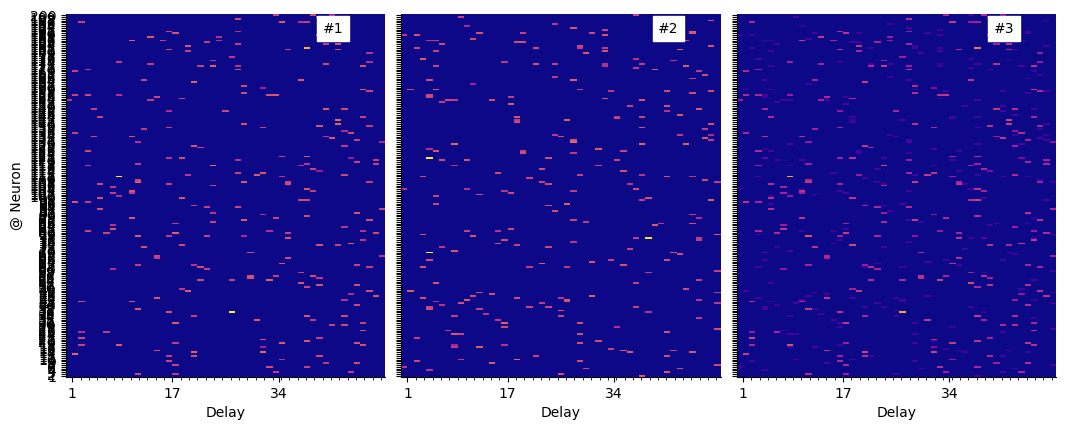

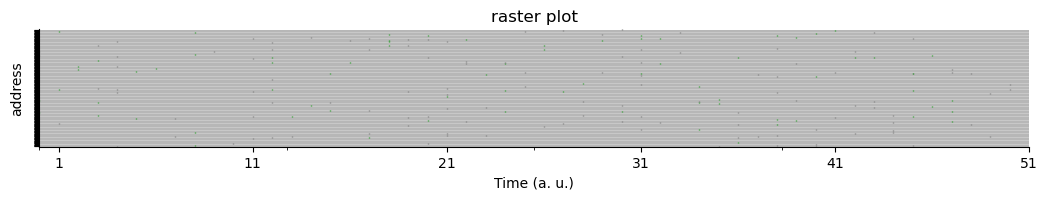

In [8]:
plot_SM(world.kernels, N_show = opt.N_kernels+1, figsize = (12, 5));
plot_raster(input_rp, colored=True);

### Format the ouput for SpikeShip

In [9]:
stacked_input = torch.Tensor([])
stacked_labels = torch.Tensor([])
for add_coef in [0, 0.2, 0.4, 0.6, 0.8, 1]:
    N_trials = 200
    world.add_coef = add_coef
    world.kernels[-1, :, :] = (1-add_coef)*world.kernels[0, :, :] + add_coef*world.kernels[1, :, :]
    input_rp, output_labels = world.draw_input_one_sm(N_trials = N_trials)
    output_labels = output_labels.clone().detach().to(torch.float32)
    output_labels[output_labels==2] = add_coef
    stacked_input = torch.vstack([stacked_input,input_rp]) if stacked_input.shape[0]>0 else input_rp
    stacked_labels = torch.hstack([stacked_labels,output_labels]) if stacked_input.shape[0]>0 else output_labels
#spike_times, ii_spike_times = tensor2spikeship(stacked_input)

In [10]:
print(np.unique(stacked_labels))

[0.  0.2 0.4 0.6 0.8 1. ]


In [11]:
input_rp, labels = stacked_input, stacked_labels

In [12]:
spike_times, ii_spike_times = tensor2spikeship(input_rp)
ii_spike_times = ii_spike_times.astype('int32')
labels = labels.numpy()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:22<00:00, 52.40it/s]


In [13]:
input_rp.shape

torch.Size([1200, 200, 51])

In [14]:
ii_spike_times.shape

(1200, 200, 2)

In [15]:
spike_times.shape

(453726,)

In [16]:
%%time
S_dist = spikeship.distances(spike_times, ii_spike_times)

CPU times: user 3min 24s, sys: 457 ms, total: 3min 25s
Wall time: 1.14 s


In [17]:
np.isnan(S_dist).sum()/(S_dist.shape[0]**2)

0.0

In [18]:
si = np.argsort(labels)

### Dissimilarity matrix

/tmp/ipykernel_3628186/3821034965.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(labels[si][[0,200,400,600,800,1000]]); #axs.set_ylabel("Epoch");


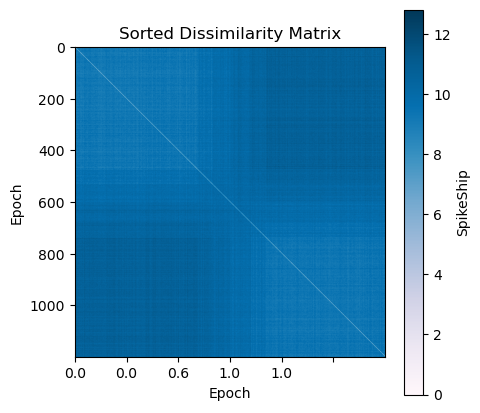

In [19]:
fig, axs = plt.subplots(figsize=(5,5), facecolor='w')
axs.set_xlabel("Epoch"); axs.set_ylabel("Epoch");
axs.set_xticklabels(labels[si][[0,200,400,600,800,1000]]); #axs.set_ylabel("Epoch");
im = axs.imshow(S_dist[:,si][si], cmap='PuBu')
axs.set_title("Sorted Dissimilarity Matrix")
cbar = plt.colorbar(im, ax=axs)
cbar.set_label("SpikeShip", fontsize=10)

## Linear dimensionnality reduction methods
### Principal component analysis

In [20]:
pca = PCA(n_components=2)
pca.fit(S_dist)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.5774271  0.05542117]
[694.54035919 215.17250065]


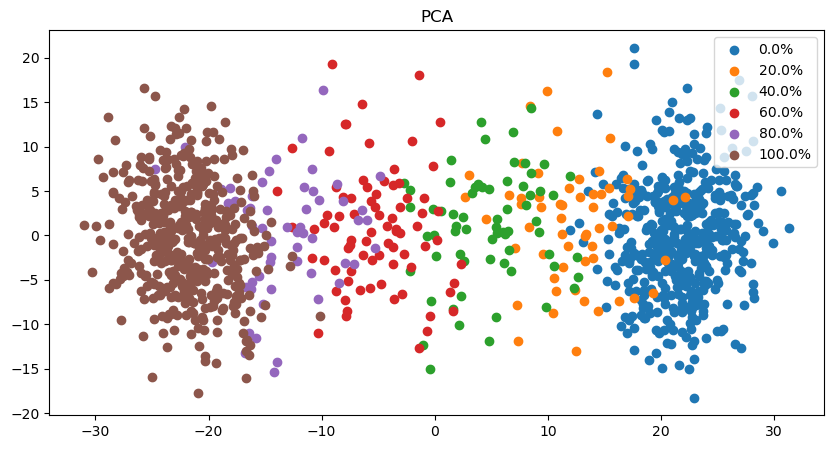

In [21]:
fig, ax = plt.subplots(figsize=(10,5))
for l in np.unique(labels):
    ax.scatter(pca.fit_transform(S_dist)[labels==l,0], pca.fit_transform(S_dist)[labels==l,1], label=f'{np.round(l*100)}%')
    ax.legend(loc='upper right')
ax.set_title('PCA');

In [22]:
pca.fit_transform(S_dist).shape

(1200, 2)

### Singular value decomposition 

In [23]:
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
svd.fit(S_dist)
print(svd.explained_variance_ratio_)
print(svd.explained_variance_ratio_.sum())
print(svd.singular_values_)

[0.05505188 0.57695763]
0.632009513789597
[11974.05973572   694.25881647]


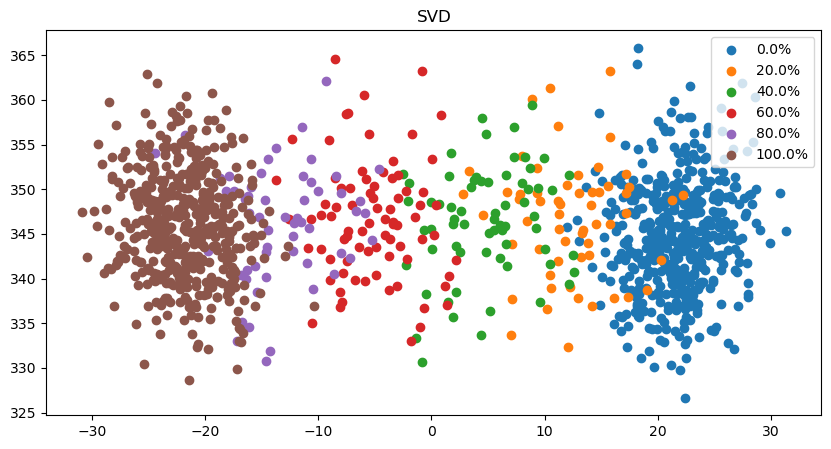

In [24]:
fig, ax = plt.subplots(figsize=(10,5))
for l in np.unique(labels):
    ax.scatter(svd.fit_transform(S_dist)[labels==l,1], svd.fit_transform(S_dist)[labels==l,0], label=f'{np.round(l*100)}%')
    ax.legend(loc='upper right')
ax.set_title('SVD');

## Non-linear dimensionnality reduction methods
### Multidimensionnal scaling

In [25]:
mds_embedding = MDS(n_components=2, dissimilarity='precomputed').fit_transform(S_dist)# metric=True, normalized_stress='auto')

/gs/home/grimaldiav/.conda/envs_ppc/ppc-spikeship/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


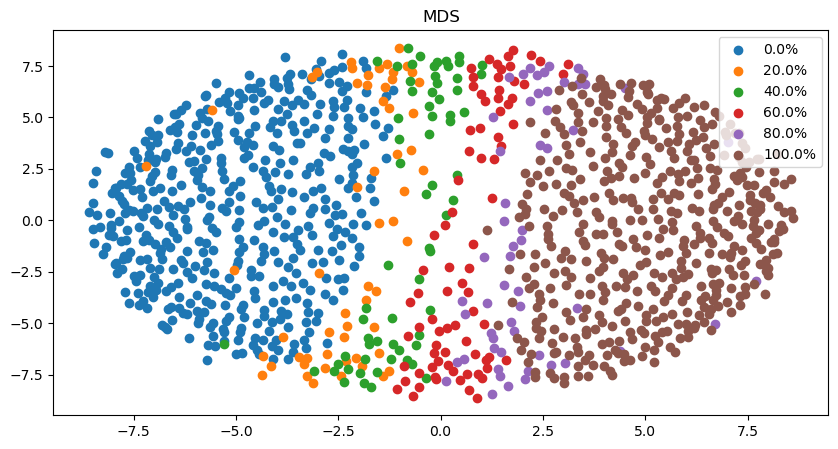

In [26]:
fig, ax = plt.subplots(figsize=(10,5))
for l in np.unique(labels):
    ax.scatter(mds_embedding[labels==l,0], mds_embedding[labels==l,1], label=f'{np.round(l*100)}%')
    ax.legend(loc='upper right')
ax.set_title('MDS');

### Laplacian eigenmaps

In [27]:
s_embedding = spectral_embedding(S_dist, n_components=2)#.fit_transform(S_dist)

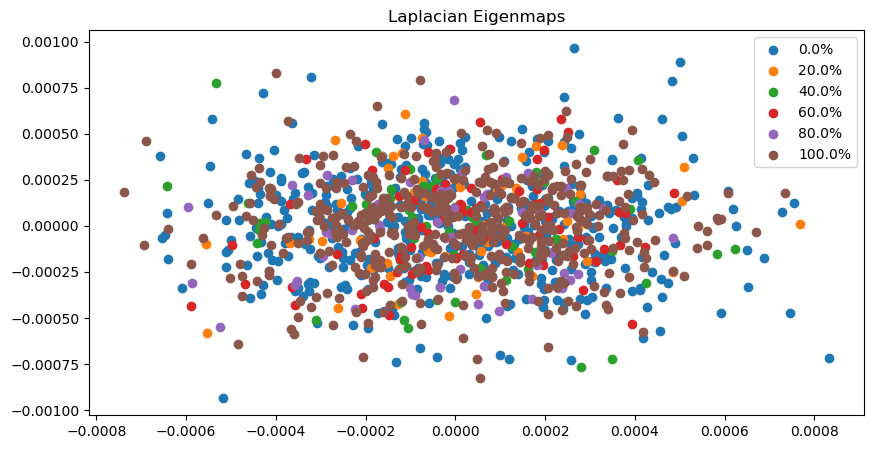

In [28]:
fig, ax = plt.subplots(figsize=(10,5))
for l in np.round(np.unique(labels),2):
    #print(np.round(l,2))
    ax.scatter(s_embedding[labels==l,0], s_embedding[labels==l,1], label=f'{np.round(l*100)}%')
    ax.legend()
ax.set_title('Laplacian Eigenmaps');

/tmp/ipykernel_3628186/3821034965.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(labels[si][[0,200,400,600,800,1000]]); #axs.set_ylabel("Epoch");


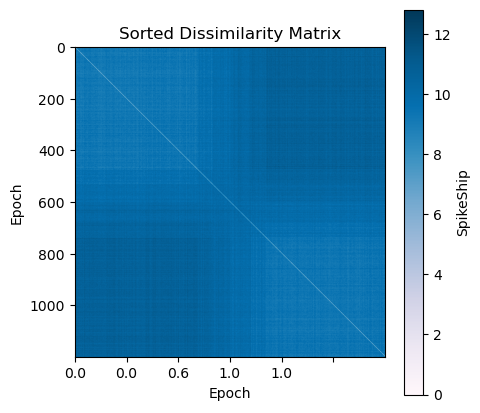

In [29]:
fig, axs = plt.subplots(figsize=(5,5), facecolor='w')
axs.set_xlabel("Epoch"); axs.set_ylabel("Epoch");
axs.set_xticklabels(labels[si][[0,200,400,600,800,1000]]); #axs.set_ylabel("Epoch");
im = axs.imshow(S_dist[:,si][si], cmap='PuBu')
axs.set_title("Sorted Dissimilarity Matrix")
cbar = plt.colorbar(im, ax=axs)
cbar.set_label("SpikeShip", fontsize=10)

### 2D t-SNE emb

In [30]:
def get_2d_tsne_embedding(diss, perplexity=70.):
    return TSNE(metric='precomputed', n_components=2, random_state=0, perplexity=perplexity, init='random').fit_transform(diss)

In [31]:
S_emb = get_2d_tsne_embedding(S_dist, perplexity = 30)

/tmp/ipykernel_3628186/3489670282.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs.scatter(S_emb[temp_mask,0], S_emb[temp_mask,1], s = 5, cmap='Set1')


Text(0.5, 1.0, '2D t-SNE embedding')

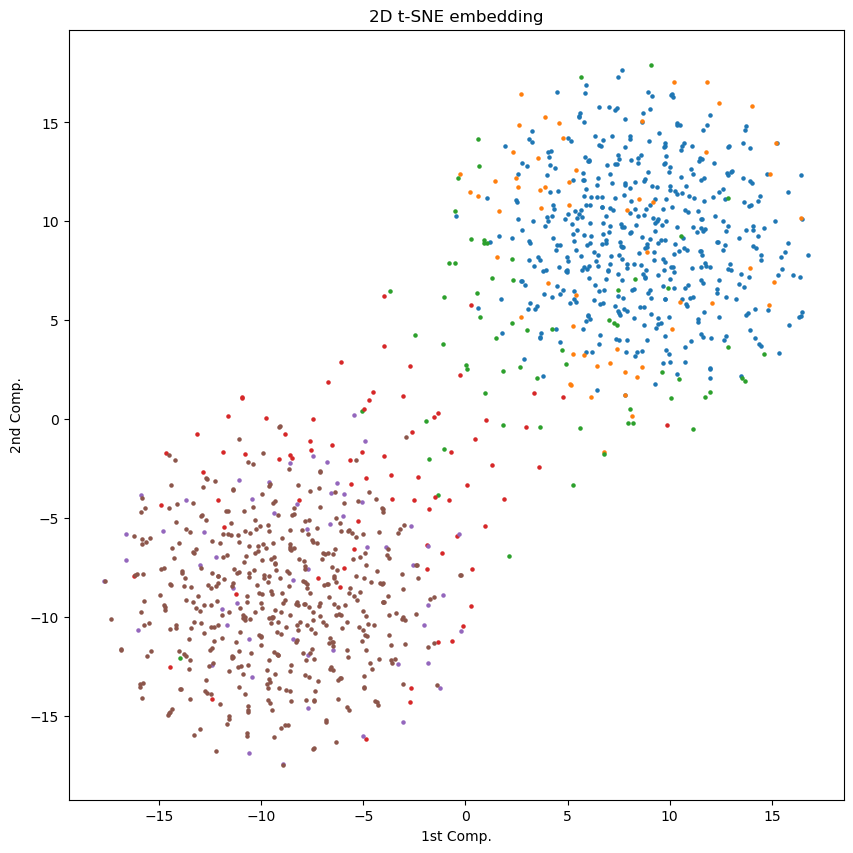

In [32]:
fig, axs = plt.subplots(facecolor='w', figsize=(10,10))
unique_labels = np.unique(labels)
for i in range(len(unique_labels)):
    label_id = unique_labels[i]
    temp_mask = labels == label_id
    axs.scatter(S_emb[temp_mask,0], S_emb[temp_mask,1], s = 5, cmap='Set1')
axs.set_xlabel("1st Comp.")
axs.set_ylabel("2nd Comp.")

axs.set_title('2D t-SNE embedding') 

From this notebook, it seems that linear dimensionnal reduction techniques are good candidate for the present task. Maybe due to the generative model that makes a linear mixture of the 2 first patterns. It can be interesting to test other generative models for the raster plots. To add spontaneous activity and also to add more patterns for the mixture of patterns. 

**`Missing:`**
+ label of each epoch.

**`Change`**:
+ Span pattern across window length or
+ Reduce SNR.

**``TODO:``**

Make different combinations of two sources in discrete steps (i.e. $\lambda=\{0,0.2,0.4,...,1\}$, then $P_3 \equiv \lambda_i P_1 + (1-\lambda_i) P_2$).

### Clustering performance

Requirements:
+ Patterns with discrete steps of mixture/combination